In [1]:
import uproot4
import numpy as np
import pandas as pd
import numba
import seaborn as sns
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.DQ)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName=""):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
        
#                         "Tracks":ak.zip({
#                                       "n_truthtracks":   kn_dict_ak1["n_truthtracks"],
#                                         "truthtrack_x_st3":   kn_dict_ak1["truthtrack_x_st3"],
#                                         "truthtrack_y_st3":   kn_dict_ak1["truthtrack_y_st3"],
#                                         "truthtrack_z_st3":   kn_dict_ak1["truthtrack_z_st3"],
#                                         "truthtrack_x_st1":   kn_dict_ak1["truthtrack_x_st1"],
#                                         "truthtrack_y_st1":   kn_dict_ak1["truthtrack_y_st1"],
#                                         "truthtrack_z_st1":   kn_dict_ak1["truthtrack_z_st1"],
#                                         "truthtrack_pz_st1":   kn_dict_ak1["truthtrack_pz_st1"],
#                                         "truthtrack_pz_st3":   kn_dict_ak1["truthtrack_pz_st3"],
#                                         "truthtrack_px_st3":   kn_dict_ak1["truthtrack_px_st3"],
#                                         "truthtrack_py_st3":   kn_dict_ak1["truthtrack_py_st3"],
#                                         "truthtrack_x_vtx":   kn_dict_ak1["truthtrack_x_vtx"],
#                                         "truthtrack_y_vtx":   kn_dict_ak1["truthtrack_y_vtx"],
#                                         "truthtrack_z_vtx":   kn_dict_ak1["truthtrack_z_vtx"],
#                                       }),
#                         "RecoTracks":ak.zip({
#                                       "n_tracks":   kn_dict_ak1["n_tracks"],
#                                         "track_pz_st1":   kn_dict_ak1["track_pz_st1"],
#                                         "track_x_st1":   kn_dict_ak1["track_x_st1"],
#                                         "track_y_st1":   kn_dict_ak1["track_y_st1"],
#                                         "track_x_st3":   kn_dict_ak1["track_x_st3"],
#                                         "track_y_st3":   kn_dict_ak1["track_y_st3"],
#                                         "track_px_st3":   kn_dict_ak1["track_px_st3"],
#                                         "track_py_st3":   kn_dict_ak1["track_py_st3"],
#                                         "track_pz_st3":   kn_dict_ak1["track_pz_st3"],
#                                         "track_x_CAL":   kn_dict_ak1["track_x_CAL"],
#                                         "track_y_CAL":   kn_dict_ak1["track_y_CAL"],
#                                         "track_chisq":   kn_dict_ak1["track_chisq"],
#                                       }),
#                         "Electrons":ak.zip({
#                                             "ge":      kn_dict_ak1["ge"],
#                                             "gvx":      kn_dict_ak1["gvx"],
#                                             "gvy":      kn_dict_ak1["gvy"],
#                                             "gvz":      kn_dict_ak1["gvz"],
#                                             "gpx":      kn_dict_ak1["gpx"],
#                                             "gpy":      kn_dict_ak1["gpy"],
#                                             "gpz":      kn_dict_ak1["gpz"],
#                                         }),
#                         "Hits":ak.zip({
#                                             "n_hits":    kn_dict_ak1["n_hits"],
#                                             "n_hits_d0":    kn_dict_ak1["n_hits_d0"],
#                                             "n_hits_d1":    kn_dict_ak1["n_hits_d1"],
#                                             "n_hits_d2":    kn_dict_ak1["n_hits_d2"],
#                                             "n_hits_d3p":    kn_dict_ak1["n_hits_d3p"],
#                                             "n_hits_d3m":    kn_dict_ak1["n_hits_d3m"],
#                                             "n_hits_h2x":    kn_dict_ak1["n_hits_h2x"],
#                                             "n_hits_h3x":    kn_dict_ak1["n_hits_h3x"],
#                                     }),
                        "HitsInfo":ak.zip({
                                            "hit_detID":   dq_dict_ak1["hit_detID"],
                                            "hit_edep":    dq_dict_ak1["hit_edep"],
                                            "hit_elmID":   dq_dict_ak1["hit_elmID"],
                                            "hit_truthx":  dq_dict_ak1["hit_truthx"],
                                            "hit_truthy":  dq_dict_ak1["hit_truthy"],
                                            "hit_truthz":  dq_dict_ak1["hit_truthz"],
                                    }),
                       }, depth_limit=1)
    return dq_events

def log_inf(i):
    return None if i == 0 else np.log(i) 

def plot_acceptance(mass, coupling, Nevent, acceptance, hue_norm = (0,1)):
    
    fig, ax = plt.subplots()
    im = ax.scatter(mass, coupling, c=acceptance, s=900, marker='s', cmap='Spectral_r',linewidths=0)

    fig.colorbar(im, ax=ax)

    plt.xlabel(r"$m_{A'}$ [GeV]")
    plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)
    plt.xscale('log')

    # iterate over axes of FacetGrid
    labels = ax.get_yticks() # get y labels

    new_labels = []
    for i,l in enumerate(labels):
        new_labels.append(r"$10^{%s}$"%labels[i])

    ax.set_yticklabels(new_labels) # set new labels

#     plt.show()

######## READ EVENTS
scan_dir = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/DCEM_Aprime_Electrons_Scan_z200_600_26_04_2022/"

Saving plots to:  plot/26-04-2022


## 0. Track acceptance

In [2]:
def scan_Ap_0(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Total events
            n_events = len(dq_events["GenVertex"].x)
            Nevent.append(n_events)

            #Number of events reconstructed but not triggered
            n_reco = ak.sum((ak.count(dq_events["Track_St1"].x, axis = 1) == 2)*dq_events['event_weight'].weight)

            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
    return mass, coupling, Nevent, acceptance
            
mass_0, coupling_0, Nevent_0, acceptance_0 = scan_Ap_0(scan_dir)

/tmp/ipykernel_2224427/2998370683.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


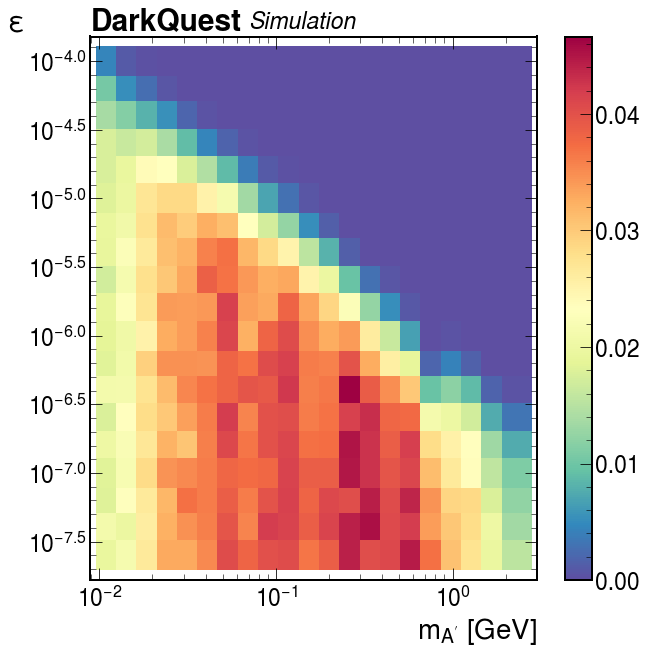

In [3]:
plot_acceptance(mass_0, coupling_0, Nevent_0, acceptance_0)
hep.dq.text("Simulation")
plt.savefig(save_path + "DP_track_accept_electrons_DC.pdf", bbox_inches='tight')

## 0.1 Track efficiency (z500-600cm)

In [4]:
def scan_Ap_01(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')
            
            gen_vertex_z = ak.firsts(dq_events["GenVertex"].z)
            
            event_selection = (gen_vertex_z >= 500) & (gen_vertex_z <= 600)

            #Total events
            n_events = len(dq_events["GenVertex"].z[event_selection])
            Nevent.append(n_events)
            
            track_st1_x = dq_events["Track_St1"].x[event_selection]
            event_weight = dq_events['event_weight'].weight[event_selection]

            #Number of events reconstructed but not triggered
            n_reco = ak.sum((ak.count(track_st1_x, axis = 1) == 2)*event_weight)
            
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
    return mass, coupling, Nevent, acceptance
            
mass_01, coupling_01, Nevent_01, acceptance_01 = scan_Ap_01(scan_dir)

/tmp/ipykernel_2224427/2998370683.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


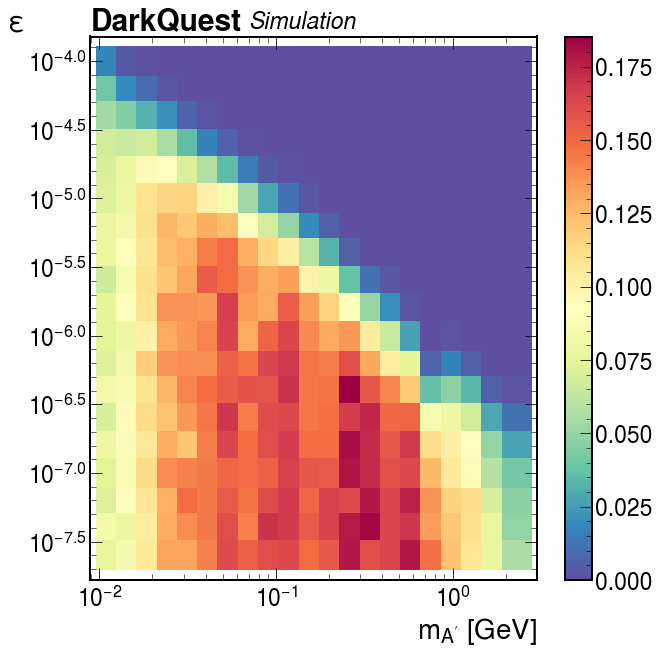

In [5]:
plot_acceptance(mass_01, coupling_01, Nevent_01, acceptance_01)
hep.dq.text("Simulation")
plt.savefig(save_path + "DP_track_accept_electrons_z500_600_DC.pdf", bbox_inches='tight')

## 1. Implement the trigger

In [7]:
def Ecal_trigger(dq_events, E_thres = 2.):
    
    #Select the hits within Ecal
    def emcal_selection(arr):
        mask = (arr.hit_detID == 100)
        return mask
    
    #Another way to calculate the total E
    ecal_mask =  emcal_selection(dq_events["HitsInfo"])
    emcal_hits = dq_events["HitsInfo"][ecal_mask]
    totalEBKG = ak.sum(emcal_hits.hit_edep, axis = 1)
    
    triggered_events = totalEBKG > E_thres
        
    return triggered_events

In [8]:
#For testing
# dq_events = getData(scan_dir+"Brem_0.212958_z500_600_eps_-7.2.root", 'Events')
# Ecal_trigger(dq_events)

## 2. Trigger acceptance

### 2.1 > 2 GeV Theshold

In [9]:
def scan_Ap_21(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Total events
            n_events = len(dq_events["nTrack"])
            Nevent.append(n_events)

            #Number of events reconstructed but not triggered
            n_reco = ak.sum(Ecal_trigger(dq_events)*dq_events['event_weight'].weight)

            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
    return mass, coupling, Nevent, acceptance
            
mass_21, coupling_21, Nevent_21, acceptance_21 = scan_Ap_21(scan_dir)

/tmp/ipykernel_2224427/2998370683.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


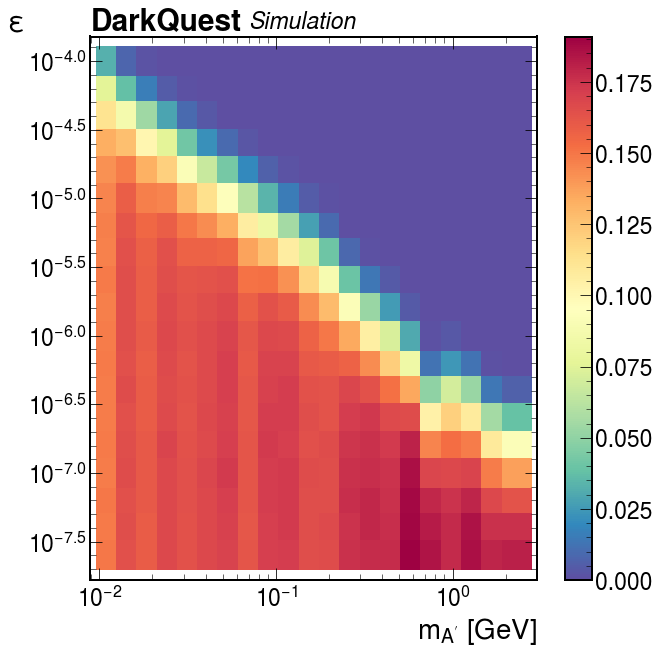

In [10]:
plot_acceptance(mass_21, coupling_21, Nevent_21, acceptance_21)
hep.dq.text("Simulation")
plt.savefig(save_path + "DP_Ecaltrigger2GeV_accept_electrons_DC.pdf", bbox_inches='tight')

## 2.1.2 z500-600

In [11]:
def Ecal_trigger_22(dq_events, event_selection, E_thres = 2.):
    
    #Select the hits within Ecal
    def emcal_selection(arr):
        mask = (arr.hit_detID == 100)
        return mask & event_selection
    
    #Another way to calculate the total E
    ecal_mask =  emcal_selection(dq_events["HitsInfo"])
    emcal_hits = dq_events["HitsInfo"][ecal_mask]
    totalEBKG = ak.sum(emcal_hits.hit_edep, axis = 1)
    
    triggered_events = totalEBKG > E_thres
        
    return triggered_events

def scan_Ap_22(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')
            
            gen_vertex_z = ak.firsts(dq_events["GenVertex"].z)
            
            event_selection = (gen_vertex_z >= 500) & (gen_vertex_z <= 600)

            #Total events
            n_events = len(dq_events["GenVertex"].z[event_selection])
            Nevent.append(n_events)
            
            event_weight = dq_events['event_weight'].weight[event_selection]

            #Number of events reconstructed but not triggered
            n_reco = ak.sum(Ecal_trigger_22(dq_events, event_selection)*dq_events['event_weight'].weight)

            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
    return mass, coupling, Nevent, acceptance
            
mass_22, coupling_22, Nevent_22, acceptance_22 = scan_Ap_22(scan_dir)

/tmp/ipykernel_2224427/2998370683.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


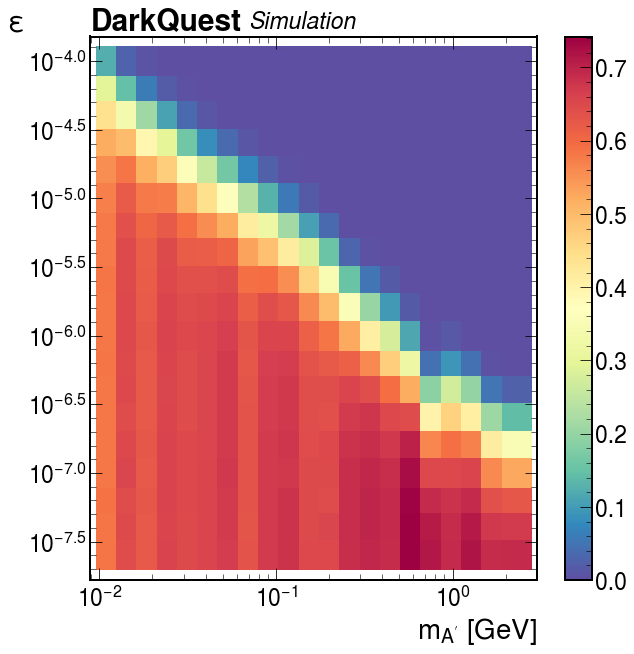

In [12]:
plot_acceptance(mass_22, coupling_22, Nevent_22, acceptance_22)
hep.dq.text("Simulation")
plt.savefig(save_path + "DP_Ecaltrigger2GeV_accept_electrons_z200_600_DC.pdf", bbox_inches='tight')

### 2.2 > 1 GeV threshold

In [5]:
#With a different threshold
def scan_Ap_1(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Total events
            n_events = len(dq_events["nTrack"])
            Nevent.append(n_events)

            #Number of events reconstructed but not triggered
            n_reco = ak.sum(Ecal_trigger(dq_events, 1.)*dq_events['event_weight'].weight)

            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
    return mass, coupling, Nevent, acceptance
            
mass_1, coupling_1, Nevent_1, acceptance_1 = scan_Ap_1(scan_dir)

/tmp/ipykernel_4045643/3305561428.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


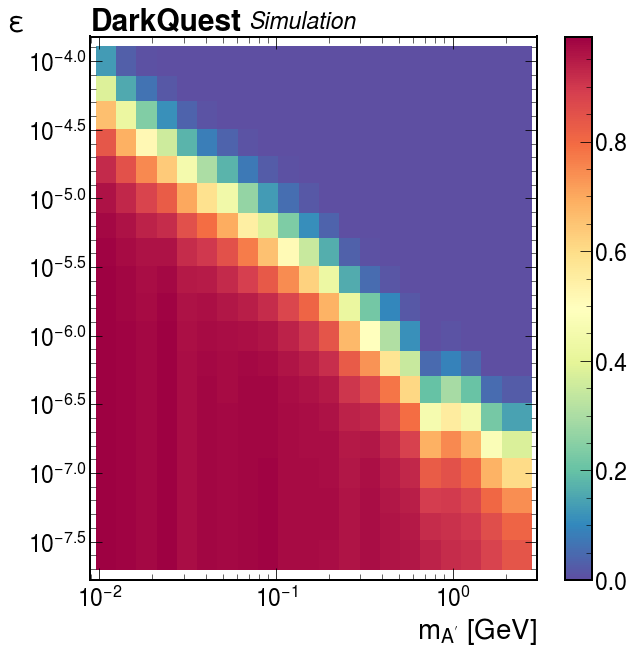

In [9]:
plot_acceptance(mass_1, coupling_1, Nevent_1, acceptance_1)
hep.dq.text("Simulation")
plt.savefig(save_path + "DP_Ecaltrigger1GeV_accept_electrons.pdf", bbox_inches='tight')